In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import tensorflow as tf

import data
import plotutils
import train
import utils
from models import MlpVae
from tcav import compute_and_print_tcav
from utils import build_tensor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Output result folders
os.makedirs('./figs/simple/conf', exist_ok=True)
os.makedirs('./figs/simple/pure', exist_ok=True)

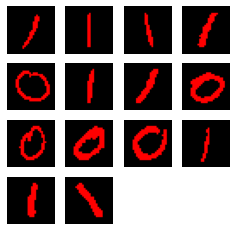

In [2]:
# Initialization

seed = 43
tf.random.set_seed(seed)
np.random.seed(seed)

color_red = (255., 0., 0.)
color_green = (0., 255., 0.)
color_white = (255., 255., 255.)

train_images_red, train_labels_red, test_images_red, test_labels_red = data.load_preprocessed_mnist(colors=[color_red], digits=[0, 1])
train_images_green, train_labels_green, test_images_green, test_labels_green = data.load_preprocessed_mnist(colors=[color_green], digits=[0, 1])
train_images = np.concatenate((train_images_red, train_images_green))
train_labels = np.concatenate((train_labels_red, train_labels_green))
test_images = np.concatenate((test_images_red, test_images_green))
test_labels = np.concatenate((test_labels_red, test_labels_green))

plotutils.plot_predictions(train_images[26:40])

train_size = train_images.shape[0]
batch_size = 32
test_size = int(train_size / 6.)
latent_dim = 2
vae_pure_single = MlpVae(latent_dim, multi_layered=False, save_path='./checkpoints/mlp_pure_single/')
vae_conf_multi = MlpVae(latent_dim, multi_layered=True, save_path='./checkpoints/mlp_confounded_multi/')

In [3]:
# Pure VAE Training
seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

train_dataset = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_images, tf.float32))
                 .shuffle(train_size, seed=0).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_images, tf.float32))
                .shuffle(test_size, seed=-1).batch(batch_size))

train.train(vae_pure_single, train_dataset, test_dataset, additional_epochs=100, status_report_interval=10)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 10, Test set ELBO: -17.108901977539062, time elapse for current epoch: 1.39689040184021
Epoch: 20, Test set ELBO: -16.648937225341797, time elapse for current epoch: 1.331202507019043
Epoch: 30, Test set ELBO: -16.366575241088867, time elapse for current epoch: 1.373682975769043
Epoch: 40, Test set ELBO: -16.202817916870117, time elapse for current epoch: 1.4919698238372803
Epoch: 50, Test set ELBO: -16.102294921875, time elapse for current epoch: 1.3167836666107178
Epoch: 60, Test set ELBO: -16.046525955200195, time elapse for current epoch: 1.3559982776641846
Epoch: 70, Test set ELBO: -15.923883438110352, time elapse for current epoch: 1.2916934490203857
Epoch: 80, Test set ELBO: -15.848660469055176, time elapse for current epoch: 1.2652060985565186
Epoch: 90, Test set ELBO: -15.842852592468262, time elapse for current epoch: 1.342151165008545
Epoch: 100, Test set ELBO: -15.786585807800293, time elapse for current epoch: 1.3599603176116943


In [4]:
# Not reproducible
tf.compat.v1.reset_default_graph()
seed = 9
# Confounded VAE Training
tf.random.set_seed(seed)
np.random.seed(seed)

train_images_conf = np.concatenate((train_images_red[train_labels_red == 0], train_images_green[train_labels_green == 1]))
test_images_conf = np.concatenate((test_images_red[test_labels_red == 0], test_images_green[test_labels_green == 1]))

train_size_conf = train_images_conf.shape[0]
test_size_conf = int(train_size_conf / 6)

train_dataset_conf = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_images_conf, tf.float32))
                 .shuffle(train_size_conf, seed=0).batch(batch_size))
test_dataset_conf = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_images_conf, tf.float32))
                .shuffle(test_size_conf, seed=-1).batch(batch_size))

train.train(vae_conf_multi, train_dataset_conf, test_dataset_conf, additional_epochs=100, status_report_interval=10)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 10, Test set ELBO: -15.558273315429688, time elapse for current epoch: 1.0500004291534424
Epoch: 20, Test set ELBO: -15.184236526489258, time elapse for current epoch: 1.090003252029419
Epoch: 30, Test set ELBO: -15.07054328918457, time elapse for current epoch: 1.0209994316101074
Epoch: 40, Test set ELBO: -14.767937660217285, time elapse for current epoch: 1.0253686904907227
Epoch: 50, Test set ELBO: -14.865251541137695, time elapse for current epoch: 1.0251953601837158
Epoch: 60, Test set ELBO: -14.90487003326416, time elapse for current epoch: 1.0633525848388672
Epoch: 70, Test set ELBO: -14.783002853393555, time elapse for current epoch: 1.01499605178833
Epoch: 80, Test set ELBO: -14.828642845153809, time elapse for current epoch: 1.0589709281921387
Epoch: 90, Test set ELBO: -14.592010498046875, time elapse for current epoch: 1.0690007209777832
Epoch: 100, Test set ELBO: -14.684157371520996, time elapse for current epoch: 1.0770001411437988


In [5]:
# Prepare data and models for TCAV computation 
vae_pure_single.load(epoch=100)
vae_conf_multi.load(epoch=100)
seed = 1337
tf.random.set_seed(seed)
np.random.seed(seed)

n_concept_samples = 100

red_0 = test_images_red[test_labels_red == 0]
red_1 = test_images_red[test_labels_red == 1]
green_0 = test_images_green[test_labels_green == 0]
green_1 = test_images_green[test_labels_green == 1]

red = data.concept_color_img_tol(r=255., r_eps=15., g=0., g_eps=15., b=0., b_eps=15., n_images=n_concept_samples*100, img_shape=(28, 28))
green = data.concept_color_img_tol(r=0., r_eps=15., g=255., g_eps=15., b=0., b_eps=15., n_images=n_concept_samples*100, img_shape=(28, 28))
_, _, white_images, white_labels = data.load_preprocessed_mnist(colors=[color_white], digits=[0, 1])
white_0 = white_images[white_labels == 0]
white_1 = white_images[white_labels == 1]

In [6]:
# Compute TCAV scores
n_concept_samples = 100
seed = 1337
clf_color_pure, clf_shape_pure, tcav_pure = compute_and_print_tcav(vae_pure_single, (red_0, red_1), (green_0, green_1), (red_0, green_0), (red_1, green_1), seed=seed, n_concept_samples=n_concept_samples)

clf_r0g1_conf, clf_color_conf, tcav_r0g1_color_conf = compute_and_print_tcav(vae_conf_multi, red_0, green_1, (red_0, red_1), (green_0, green_1), seed=seed, n_concept_samples=n_concept_samples)
_, clf_shape_conf, tcav_r0g1_shape_conf = compute_and_print_tcav(vae_conf_multi, red_0, green_1, (red_0, green_0), (red_1, green_1), seed=seed, n_concept_samples=n_concept_samples)

TCAV=0.08182588219642639
Val Acc A = 1.0
Val Acc B = 0.9750000238418579
TCAV=0.9729776978492737
Val Acc A = 1.0
Val Acc B = 0.925000011920929
TCAV=0.6667497158050537
Val Acc A = 1.0
Val Acc B = 0.6499999761581421


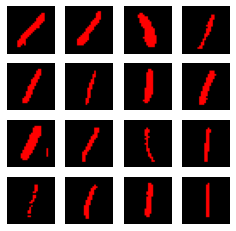

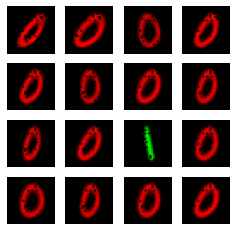

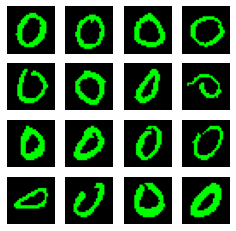

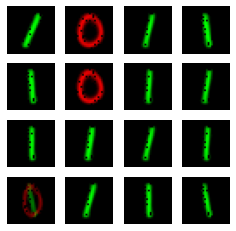

In [7]:
pos = build_tensor(red_1, n_concept_samples=16)
neg = build_tensor(green_0, n_concept_samples=16)
pos = utils.dataset_to_tensor(pos, n_elements=16)
neg = utils.dataset_to_tensor(neg, n_elements=16)
plotutils.plot_predictions(pos, filename='./figs/simple/conf/red_1_in.png')
plotutils.plot_reconstructed_images(vae_conf_multi, pos, filename='./figs/simple/conf/red_1_out.png')
plotutils.plot_predictions(neg, filename='./figs/simple/conf/green_0_in.png')
plotutils.plot_reconstructed_images(vae_conf_multi, neg, filename='./figs/simple/conf/green_0_out.png')

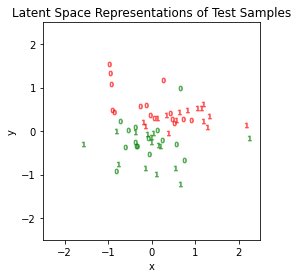

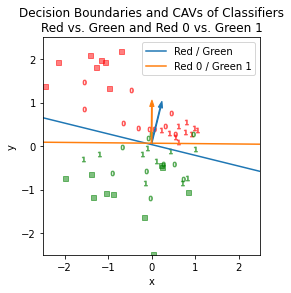

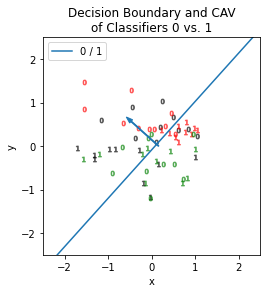

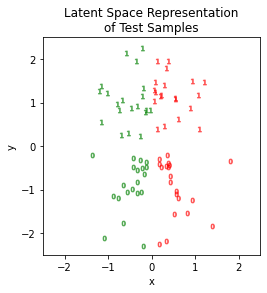

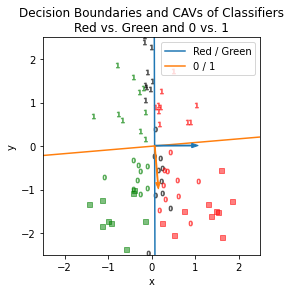

In [8]:
seed=0
tf.random.set_seed(seed)
np.random.seed(seed)
images_to_plot = [
        (red_0, 'r', '$0$'),
        (red_1, 'r', '$1$'),
        (green_0, 'g', '$0$'),
        (green_1, 'g', '$1$'),
    ]

clfs = []
legend = []
title = 'Latent Space Representations of Test Samples'
cav_origin = (0., -0.05)
save_file_path = 'figs/simple/conf/latent_space.png'
plotutils.plot_data(vae_conf_multi, images_to_plot, clfs, cav_origin, legend, title, save_file_path, n_items=15)


seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
images_to_plot = [
        (red, 'r', 's'),
        (green, 'g', 's'),
        (red_0, 'r', '$0$'),
        (red_1, 'r', '$1$'),
        (green_0, 'g', '$0$'),
        (green_1, 'g', '$1$'),
    ]

clfs = [
    (clf_color_conf, u'#1f77b4', True),   #blue
    (clf_r0g1_conf, u'#ff7f0e', True)    #orange
]
legend = ['Red / Green', 'Red 0 / Green 1']
title = 'Decision Boundaries and CAVs of Classifiers\nRed vs. Green and Red 0 vs. Green 1'
cav_origin = (-0.003, 0.06)
save_file_path = 'figs/simple/conf/color_bias.png'
plotutils.plot_data(vae_conf_multi, images_to_plot, clfs, cav_origin, legend, title, save_file_path, n_items=10)

images_to_plot = [
        (white_0, 'black', '$0$'),
        (white_1, 'black', '$1$'),
        (red_0, 'r', '$0$'),
        (red_1, 'r', '$1$'),
        (green_0, 'g', '$0$'),
        (green_1, 'g', '$1$'),
    ]
tf.random.set_seed(seed)
np.random.seed(seed)
clfs = [
    (clf_shape_conf, u'#1f77b4', False),   #blue
]
legend = ['0 / 1',]
title = 'Decision Boundary and CAV\nof Classifiers 0 vs. 1'
cav_origin = (0.16, 0.)
save_file_path = 'figs/simple/conf/shape.png'
plotutils.plot_data(vae_conf_multi, images_to_plot, clfs, cav_origin, legend, title, save_file_path, n_items=10)


tf.random.set_seed(seed)
np.random.seed(seed)
images_to_plot = [
        (red_0, 'r', '$0$'),
        (red_1, 'r', '$1$'),
        (green_0, 'g', '$0$'),
        (green_1, 'g', '$1$'),
    ]
clfs = []
legend = []
title = 'Latent Space Representation\nof Test Samples'
save_file_path = 'figs/simple/pure/latent_space.png'
plotutils.plot_data(vae_pure_single, images_to_plot, clfs, cav_origin, legend, title, save_file_path, n_items=20)


tf.random.set_seed(seed)
np.random.seed(seed)
images_to_plot = [
        (red, 'r', 's'),
        (green, 'g', 's'),
        (white_0, 'black', '$0$'),
        (white_1, 'black', '$1$'),
        (red_0, 'r', '$0$'),
        (red_1, 'r', '$1$'),
        (green_0, 'g', '$0$'),
        (green_1, 'g', '$1$'),
    ]
clfs = [
    (clf_color_pure, u'#1f77b4', True),   #blue
    (clf_shape_pure, u'#ff7f0e', True)    #orange
]
legend = ['Red / Green', '0 / 1']
title = 'Decision Boundaries and CAVs of Classifiers\nRed vs. Green and 0 vs. 1'
cav_origin = (0.07, 0.01)
save_file_path = 'figs/simple/pure/color_shape.png'
plotutils.plot_data(vae_pure_single, images_to_plot, clfs, cav_origin, legend, title, save_file_path, n_items=10)


In [9]:
# CAV validation
from metrics import PosNegAccuracy

def compute_accuracy(pos_examples, neg_examples, model, clf):
    pos_examples = build_tensor(pos_examples)
    neg_examples = build_tensor(neg_examples)
    pos_enc = [model.reparameterize(*model.encode(x)) for x in pos_examples]
    neg_enc = [model.reparameterize(*model.encode(x)) for x in neg_examples]
    y_pred = clf.predict(tf.squeeze(tf.convert_to_tensor(pos_enc + neg_enc)))
    y_true = np.array([1.]*100 + [-1.]*100)
    x = PosNegAccuracy()(y_true, y_pred)
    print("Test Acc = {}".format(x))

compute_accuracy(white_0, white_1, vae_pure_single, clf_shape_pure)
compute_accuracy(red, green, vae_pure_single, clf_color_pure)
compute_accuracy(white_0, white_1, vae_conf_multi, clf_shape_conf)
compute_accuracy(red, green, vae_conf_multi, clf_color_conf)
compute_accuracy(red_0, green_1, vae_conf_multi, clf_r0g1_conf)

Test Acc = 0.949999988079071
Test Acc = 0.925000011920929
Test Acc = 0.6800000071525574
Test Acc = 0.949999988079071
Test Acc = 1.0
